In [7]:
pwd

'/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0'

In [2]:
cd ~/cg1/Golitzin/SWEMLv2.0/Dataprocessing

/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0/Dataprocessing


In [1]:
import numpy as np
import pandas as pd
import ee #pip install earthengine-api
import geemap
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import concurrent.futures as cf
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
ee.Authenticate()
ee.Initialize()
import warnings
import boto3
warnings.filterwarnings("ignore")

import pydaymet as daymet
import rasterio
import geopandas as gpd
from shapely.geometry import box
import pyproj
from rasterio.plot import show
import geopandas as gpd
import rioxarray as rxr
import contextily as cx
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
os.environ['PROJ_LIB'] =pyproj.datadir.get_data_dir()

In [4]:
#load access key
#HOME = os.getcwd()
HOME = os.chdir('..')
HOME = os.getcwd()
#HOME = os.path.expanduser('~')

import utils.EE_funcs as EE_funcs

KEYPATH = "AWSaccessKeys.csv"
print(f"{HOME}/{KEYPATH}")

if os.path.isfile(f"{HOME}/{KEYPATH}") == True:
    ACCESS = pd.read_csv(f"{HOME}/{KEYPATH}")

    #start session
    SESSION = boto3.Session(
        aws_access_key_id=ACCESS['Access key ID'][0],
        aws_secret_access_key=ACCESS['Secret access key'][0],
    )
    S3 = SESSION.resource('s3')
    #AWS BUCKET information
    BUCKET_NAME = 'national-snow-model'
    #S3 = boto3.resource('S3', config=Config(signature_version=UNSIGNED))
    BUCKET = S3.Bucket(BUCKET_NAME)
else:
    print("no AWS credentials present, skipping")

/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0/AWSaccessKeys.csv
no AWS credentials present, skipping


In [5]:
ASO_Key=pd.read_csv(f"{HOME}/utils/ASONameKey.csv",header=3)
ASO_Key.head()

,SITE CODE,SITE NAME,Easting,Northing,Easting.1,Northing.1,Easting.2,Northing.2,Easting.3,Northing.3,Unnamed: 10,Longitude,Latitude,Longitude.1,Latitude.1,Longitude.2,Latitude.2,Longitude.3,Latitude.3
0,USCABI,BISHOP BORESIGHT,373773,4139361,375072.0,4139361,373773,4137315,375072.0,4137315,11,-118.425986,37.39243,-118.411315,37.392603,-118.425636,37.37399,-118.410969,37.37417
1,USCABO,USCA_BODIE_GT,323145,4232547,325335.0,4232547,323145,4230381,325335.0,4230381,11,-119.020405,38.22354,-118.995401,38.223963,-119.019866,38.20403,-118.994868,38.20445
2,USCABP,BIG PINE,374427,4118148,384804.0,4118148,374427,4110342,384804.0,4110342,11,-118.415014,37.20136,-118.298109,37.202700,-118.413702,37.13102,-118.296907,37.13235
3,USCACE,CHERRY ELEANOR,242715,4234848,272748.0,4234848,242715,4206393,272748.0,4206393,11,-119.939137,38.22485,-119.596397,38.232936,-119.928888,37.96873,-119.587339,37.97674
4,USCACM,USCA_CHEMUNG_MINE_GT,311901,4247049,312420.0,4247049,311901,4246512,312420.0,4246512,11,-119.152633,38.35186,-119.146697,38.351970,-119.152489,38.34703,-119.146554,38.34713


In [153]:
def filename_parse(filename):
    date = next(element for element in os.path.splitext(filename)[0].split("_") if element.startswith('20'))
    if date[4].isnumeric() == False:
        date_singleday = os.path.splitext(date)[0].split("-")[0]
        datetime_object = datetime.strptime(date_singleday, "%Y%b%d")
        date = datetime_object.strftime('%Y%m%d')
    #identify basin from site code if applicable, else identify basin from name
    if filename[:12] == "ASO_50M_SWE_":
        # print(file[12:18])
        sitecode = filename[12:18]
        index = ASO_Key['SITE CODE']==sitecode
        sitename=(ASO_Key.loc[index,'SITE NAME']).item().replace(" ","_")
        # print(sitename)
        newfilename = f"{sitename}_{sitecode}_{date}"
        # print(newfilename)
    else:
        sitename = os.path.splitext(filename)[0].split("_")[1]
        newfilename = f"{sitename}_{date}"
    return(date, newfilename)

In [154]:
# getting stuck here b/c file structure is still governed by metadata for entire WY regardless of basin
# is there a way to set up the pipeline so the file dependencies are agnostic to basin and date? 
training_df_path = f"{HOME}/data/TrainingDFs/{2013}/{1000}M_Resolution/VIIRSGeoObsDFs/{20}_fSCA_Thresh/VIIRS_GeoObsDF_20130403.parquet"
training_df = pd.read_parquet(training_df_path)
meta = training_df[['cell_id','cen_lat','cen_lon']]
meta.head()

,cell_id,cen_lat,cen_lon
0,2013_1000M_38.181_-119.594,38.181,-119.594
1,2013_1000M_38.181_-119.585,38.181,-119.585
2,2013_1000M_38.172_-119.612,38.172,-119.612
3,2013_1000M_38.172_-119.603,38.172,-119.603
4,2013_1000M_38.172_-119.594,38.172,-119.594


In [37]:
def get_daymet_precip(WY,output_res,thresh):
    
    # set start date for precip obs to 10-1 of previous year
    WY_start = datetime(WY-1, 10, 1)
    obs_start = WY_start.strftime('%Y-%m-%d')
    print("Water Year start date:",obs_start)
    
    # select basins, dates by ASO observation
    ASO_dir = f"{HOME}/data/ASO/{WY}/Raw_ASO_Data"
    files = [filename for filename in os.listdir(ASO_dir)
             if filename.endswith(".tif")
            ]
    print(files)
    for file in files:
        filepath = f'{ASO_dir}/{file}'
        date, newfilename = filename_parse(file)
        obs_end = f'{date[:4]}-{date[4:6]}-{date[6:]}'
        print("Getting precipitation data for",obs_end)
        with rxr.open_rasterio(filepath) as src:
            # reproject to WGS84
            transformed = src.rio.reproject(rasterio.crs.CRS.from_epsg('4326'))
            left, bottom, right, top = transformed.rio.bounds()
            # add some padding to bbox
            left -= 0.1
            bottom -= 0.1
            right += 0.1
            top += 0.1
            bbox = rasterio.coords.BoundingBox(left, bottom, right, top)
        obs_precip = daymet.get_bygeom(bbox,dates=(obs_start,obs_end),variables="prcp",crs=4326)
        obs_precip_transformed = obs_precip.rio.reproject(rasterio.crs.CRS.from_epsg('4326'))
        print(bbox)    
        # load previous training DF to extract metadata for specific observation
        training_df_path = f"{HOME}/data/TrainingDFs/{WY}/{output_res}M_Resolution/VIIRSGeoObsDFs/{thresh}_fSCA_Thresh/VIIRS_GeoObsDF_{date}.parquet"
        training_df = pd.read_parquet(training_df_path)
        meta = training_df[['cell_id','cen_lat','cen_lon']]
        # coordinates get rounded in get_VIIRS script, reassess later if need more precision
        print(meta['cen_lon'].min(),meta['cen_lon'].max(),meta['cen_lat'].min(),meta['cen_lat'].max())
        precip_arr = []
        season_precip_cm = []
        nsites = len(meta)
        for i in range(nsites):
            lat, lon = meta.iloc[i]['cen_lat'],meta.iloc[i]['cen_lon']
            cellid = meta.iloc[i]['cell_id']
            if ((lon>bbox[0] and lon<bbox[2]) and (lat>bbox[1] and lat<bbox[3])):
                # print('got here')
                prcp = obs_precip_transformed.sel(x=lon,y=lat,method='nearest')['prcp']
                season_precip = np.round(np.array(prcp.values).sum()/10,2)
            # if season_precip >= 0:
                precip_arr.append([cellid,lat,lon,np.array(prcp.values)])
                season_precip_cm.append(season_precip)
        precip_df = pd.DataFrame(precip_arr,columns = ['cell_id','cen_lat','cen_lon','precip'])
        precip_df['season_precip_cm'] = season_precip_cm    
        
        # print(precip_df.head())
        
        # save raw data for each basin and date
        precip_data_path = f"{HOME}/data/Precipitation/{WY}/{output_res}M_Daymet_Precip"
        if not os.path.exists(precip_data_path):
            os.makedirs(precip_data_path, exist_ok=True)
            
        table = pa.Table.from_pandas(precip_df)
        pq.write_table(table, f"{precip_data_path}/Daymet_{newfilename}.parquet", compression='BROTLI')
        
    # return season_precip

In [30]:
def get_daymet_precip_multithreading(WY,output_res,thresh):
    # set start date for precip obs to Oct 1 of previous year
    WY_start = datetime(WY-1, 10, 1)
    obs_start = WY_start.strftime('%Y-%m-%d')
    print("Water Year start date:",obs_start)
    
    # select basins, dates by training DF
    training_df_dir = f"{HOME}/data/TrainingDFs/{WY}/{output_res}M_Resolution/VIIRSGeoObsDFs/{thresh}_fSCA_Thresh"
    files = [filename for filename in os.listdir(training_df_dir)
             if filename.endswith(".parquet")
            ]
    
    with cf.ThreadPoolExecutor(max_workers=CPUS/2) as executor: 
        # Start the load operations and mark each future with its process function
        {executor.submit(get_daymet_precip_single_date, (file,training_df_dir,obs_start,WY,output_res,thresh)): \
            file for file in tqdm(files)}
       

In [28]:
def get_daymet_precip_single_date(file,training_df_dir,obs_start,WY,output_res,thresh):
    # get daymet precip by grabbing bounding box from previous training DF for basin + date
    print(file)
    filepath = f'{training_df_dir}/{file}'
    #Get timestamp
    timestamp = file.split('_')[-1].split('.')[0]
    #Get region
    region = file.split('_')[-2]
    # print(timestamp,region)
    obs_end = f'{timestamp[:4]}-{timestamp[4:6]}-{timestamp[6:]}'
        
    print(f"Getting precipitation data for {obs_end} at {region}")
        
    training_df = pd.read_parquet(filepath)
    # get bounding box by min/max coordinates
    left, right = training_df['cen_lon'].min(), training_df['cen_lon'].max()
    bottom, top = training_df['cen_lat'].min(), training_df['cen_lat'].max()
    # add some padding to bbox
    left -= 0.1
    bottom -= 0.1
    right += 0.1
    top += 0.1
    bbox = rasterio.coords.BoundingBox(left, bottom, right, top)
       
    # get precip from Daymet server from beginning of WY through observation date and reproject
    obs_precip = daymet.get_bygeom(bbox,dates=(obs_start,obs_end),variables="prcp",crs=4326)
    obs_precip_transformed = obs_precip.rio.reproject(rasterio.crs.CRS.from_epsg('4326'))  
    # print(bbox)    
     
    # extract metadata 
    meta = training_df[['cell_id','cen_lat','cen_lon']]
    # coordinates get rounded in get_VIIRS script, reassess later if need more precision
    # print(meta['cen_lon'].min(),meta['cen_lon'].max(),meta['cen_lat'].min(),meta['cen_lat'].max())
    precip_arr = []
    season_precip_cm = []
    nsites = len(meta)
    for i in range(nsites):
        lat, lon = meta.iloc[i]['cen_lat'],meta.iloc[i]['cen_lon']
        cellid = meta.iloc[i]['cell_id']
        prcp = obs_precip_transformed.sel(x=lon,y=lat,method='nearest')['prcp']
        season_precip = np.round(np.array(prcp.values).sum()/10,2)
        # if season_precip >= 0:
        precip_arr.append([cellid,lat,lon,np.array(prcp.values)])
        season_precip_cm.append(season_precip)
    precip_df = pd.DataFrame(precip_arr,columns = ['cell_id','cen_lat','cen_lon','precip'])
    precip_df['season_precip_cm'] = season_precip_cm    
    # print(season_precip_cm)
    # print(precip_df.head())
        
        # save raw data for each basin and date
    precip_data_path = f"{HOME}/data/Precipitation/{WY}/{output_res}M_Daymet_Precip"
    if not os.path.exists(precip_data_path):
        os.makedirs(precip_data_path, exist_ok=True)
            
    table = pa.Table.from_pandas(precip_df)
    pq.write_table(table, f"{precip_data_path}/Daymet_{region}_{timestamp}.parquet", compression='BROTLI')
        
    # return season_precip

In [32]:
get_daymet_precip_multithreading(2024,1000,10)

Water Year start date: 2023-10-01


100%|██████████| 69/69 [00:00<00:00, 43962.78it/s]


In [38]:
def get_daymet_precip_df(WY,output_res,thresh):
    # get daymet precip by grabbing bounding box from previous training DF for basin + date
    # set start date for precip obs to Oct 1 of previous year
    WY_start = datetime(WY-1, 10, 1)
    obs_start = WY_start.strftime('%Y-%m-%d')
    print("Water Year start date:",obs_start)
    
    # select basins, dates by training DF
    training_df_dir = f"{HOME}/data/TrainingDFs/{WY}/{output_res}M_Resolution/VIIRSGeoObsDFs/{thresh}_fSCA_Thresh"
    files = [filename for filename in os.listdir(training_df_dir)
             if filename.endswith(".parquet")
            ]
    # print(files)
    for file in files:
        filepath = f'{training_df_dir}/{file}'
        #Get timestamp
        timestamp = file.split('_')[-1].split('.')[0]
        #Get region
        region = file.split('_')[-2]
        # print(timestamp,region)
        obs_end = f'{timestamp[:4]}-{timestamp[4:6]}-{timestamp[6:]}'
        
        print(f"Getting precipitation data for {obs_end} at {region}")
        
        training_df = pd.read_parquet(filepath)
        # get bounding box by min/max coordinates
        left, right = training_df['cen_lon'].min(), training_df['cen_lon'].max()
        bottom, top = training_df['cen_lat'].min(), training_df['cen_lat'].max()
        # add some padding to bbox
        left -= 0.1
        bottom -= 0.1
        right += 0.1
        top += 0.1
        bbox = rasterio.coords.BoundingBox(left, bottom, right, top)
       
        # get precip from Daymet server from beginning of WY through observation date and reproject
        obs_precip = daymet.get_bygeom(bbox,dates=(obs_start,obs_end),variables="prcp",crs=4326)
        obs_precip_transformed = obs_precip.rio.reproject(rasterio.crs.CRS.from_epsg('4326'))  
        # print(bbox)    
        
        # extract metadata 
        meta = training_df[['cell_id','cen_lat','cen_lon']]
        # coordinates get rounded in get_VIIRS script, reassess later if need more precision
        # print(meta['cen_lon'].min(),meta['cen_lon'].max(),meta['cen_lat'].min(),meta['cen_lat'].max())
        precip_arr = []
        season_precip_cm = []
        nsites = len(meta)
        for i in range(nsites):
            lat, lon = meta.iloc[i]['cen_lat'],meta.iloc[i]['cen_lon']
            cellid = meta.iloc[i]['cell_id']
            # if ((lon>bbox[0] and lon<bbox[2]) and (lat>bbox[1] and lat<bbox[3])):
                # print('got here')
            prcp = obs_precip_transformed.sel(x=lon,y=lat,method='nearest')['prcp']
            season_precip = np.round(np.array(prcp.values).sum()/10,2)
            # if season_precip >= 0:
            precip_arr.append([cellid,lat,lon,np.array(prcp.values)])
            season_precip_cm.append(season_precip)
        precip_df = pd.DataFrame(precip_arr,columns = ['cell_id','cen_lat','cen_lon','precip'])
        precip_df['season_precip_cm'] = season_precip_cm    
        # print(season_precip_cm)
        # print(precip_df.head())
        
        # save raw data for each basin and date
        precip_data_path = f"{HOME}/data/Precipitation/{WY}/{output_res}M_Daymet_Precip"
        if not os.path.exists(precip_data_path):
            os.makedirs(precip_data_path, exist_ok=True)
            
        table = pa.Table.from_pandas(precip_df)
        pq.write_table(table, f"{precip_data_path}/Daymet_{region}_{timestamp}.parquet", compression='BROTLI')
        
    # return season_precip

In [272]:
WYs = [2024]
res = [1000]
for year in WYs:
    for output_res in res:
        get_daymet_precip_df(year,output_res,thresh=10)

Water Year start date: 2019-10-01
Getting precipitation data for 2020-05-21
Getting precipitation data for 2020-06-04
Getting precipitation data for 2020-04-13
Getting precipitation data for 2020-05-07
Getting precipitation data for 2020-05-21
Getting precipitation data for 2020-04-13
Getting precipitation data for 2020-05-07
Getting precipitation data for 2020-04-14
Getting precipitation data for 2020-04-11
Getting precipitation data for 2020-05-04
Getting precipitation data for 2020-05-29
Getting precipitation data for 2020-05-02
Getting precipitation data for 2020-05-23
Getting precipitation data for 2020-06-08
Water Year start date: 2020-10-01
Getting precipitation data for 2021-04-20
Getting precipitation data for 2021-05-24
Getting precipitation data for 2021-04-18
Getting precipitation data for 2021-05-16
Getting precipitation data for 2021-04-20
Getting precipitation data for 2021-05-14
Getting precipitation data for 2021-05-04
Getting precipitation data for 2021-04-29
Getting 

KeyboardInterrupt: 

In [14]:
#set multiprocessing limits
CPUS = len(os.sched_getaffinity(0))
CPUS = int((CPUS/2)-2)

In [39]:
def Make_Precip_DF(WY,output_res,thresh,dataset):
    print(f"Adding precipitation features to ML dataframe for WY {WY}")
    precip_data_path = f"{HOME}/data/Precipitation/{WY}/{output_res}M_{dataset}_Precip"
    training_df_path = f"{HOME}/data/TrainingDFs/{WY}/{output_res}M_Resolution/VIIRSGeoObsDFs/{thresh}_fSCA_Thresh"

    #make precip df path
    precip_df_path = f"{HOME}/data/TrainingDFs/{WY}/{output_res}M_Resolution/PrecipVIIRSGeoObsDFs/{thresh}_fSCA_Thresh"
    if not os.path.exists(precip_df_path):
        os.makedirs(precip_df_path, exist_ok=True)

    #Get list of dataframes
    GeoObsDF_files = [filename for filename in os.listdir(training_df_path)] 
    # print(GeoObsDF_files)
    
    # Multiprocessing 
    with cf.ProcessPoolExecutor(max_workers=CPUS) as executor: 
        # Start the load operations and mark each future with its process function
        [executor.submit(single_date_add_daymet_precip, (training_df_path, precip_data_path, geofile, precip_df_path, WY, dataset)) for geofile in GeoObsDF_files]
        
    # for geofile in GeoObsDF_files:
        # single_date_add_daymet_precip((training_df_path, precip_data_path, geofile, precip_df_path, WY, dataset))

In [90]:
WY=2015
output_res=1000
thresh=20
dataset = 'Daymet'
precip_data_path = f"{HOME}/data/Precipitation/{WY}/{output_res}M_{dataset}_Precip"
training_df_path = f"{HOME}/data/TrainingDFs/{WY}/{output_res}M_Resolution/VIIRSGeoObsDFs/{thresh}_fSCA_Thresh"
pptfiles = [filename for filename in os.listdir(precip_data_path) if filename.endswith('.parquet')]
pptfiles_dates = []
for i in range(len(pptfiles)):
    pptfiles_dates.append(pptfiles[i].split('_')[-1].split('.parquet')[0])

pptfiles_dates = np.array(pptfiles_dates)
unique_dates = np.unique(pptfiles_dates)
print(f'there are {len(unique_dates)} unique dates')

for i,date in enumerate(unique_dates):
    # print(date)
    idxarr = np.where(pptfiles_dates == date)
    # print(idxarr)
    # print(idxarr[0])
    date_obs = []
    for idx in idxarr[0]:
        # print(idx)
        # print(pptfiles[idx])
        date_obs.append(pptfiles[idx])
    print(i, date, date_obs)


there are 20 unique dates
0 20150217 ['Daymet_TUOLUMNE_RIVER_USCATB_20150217.parquet']
1 20150305 ['Daymet_TUOLUMNE_RIVER_USCATB_20150305.parquet']
2 20150325 ['Daymet_TUOLUMNE_RIVER_USCATB_20150325.parquet']
3 20150326 ['Daymet_RUSH_CREEK_USCARC_20150326.parquet']
4 20150403 ['Daymet_KINGS_CANYON_USCAKC_20150403.parquet', 'Daymet_TUOLUMNE_RIVER_USCATB_20150403.parquet']
5 20150406 ['Daymet_CONEJOS_RIVER_USCOCJ_20150406.parquet']
6 20150407 ['Daymet_RIO_GRANDE_RIVER_USCORG_20150407.parquet']
7 20150409 ['Daymet_TUOLUMNE_RIVER_USCATB_20150409.parquet']
8 20150412 ['Daymet_KINGS_CANYON_USCAKC_20150412.parquet']
9 20150415 ['Daymet_TUOLUMNE_RIVER_USCATB_20150415.parquet']
10 20150426 ['Daymet_KINGS_CANYON_USCAKC_20150426.parquet']
11 20150427 ['Daymet_TUOLUMNE_RIVER_USCATB_20150427.parquet']
12 20150428 ['Daymet_LAKES_BASIN_USCALB_20150428.parquet', 'Daymet_MERCED_RIVER_USCAMB_20150428.parquet']
13 20150503 ['Daymet_RUSH_CREEK_USCARC_20150503.parquet']
14 20150527 ['Daymet_RUSH_CREEK_USCA

In [40]:
def single_date_add_daymet_precip(args):
    training_df_path, precip_data_path, geofile, precip_df_path, WY, dataset = args
    #get date information
    # print(geofile)
    date = geofile.split('_')[-1].split('.parquet')[0]
    region = geofile.split('_')[-2]
    # print(region,date)
    region_date = f"{region}_{date}"
    # print(region_date)
    year = date[:4]
    mon = date[4:6]
    day = date[6:]
    strdate = f"{year}-{mon}-{day}"
    print(f"Connecting precipitation to ASO observations for {WY} on {strdate} at {region}")
    
    GDF = pd.read_parquet(os.path.join(training_df_path, geofile))
    GDF.set_index('cell_id', inplace = True)
    GDF['season_precip_cm'] = 0.0
    
    # get precip filenames
    pptfiles = [filename for filename in os.listdir(precip_data_path) if filename.endswith('.parquet')]
    # print(pptfiles)
    # need to connect GDF to precip file(s) by date and basin
    # this is clunky but will work for now
    pptfiles_region_date = []
    for i in range(len(pptfiles)):
        pptfile_date = pptfiles[i].split('_')[-1].split('.parquet')[0]
        pptfile_region = pptfiles[i].split('_')[-2]
        pptfile_reg_date = f"{pptfile_region}_{pptfile_date}"
        pptfiles_region_date.append(pptfile_reg_date)
    # unique_dates = np.unique(pptfiles_dates)
    
    ppt_filename = [filename for filename in pptfiles if region_date in filename]
    # print(region_date, ppt_filename)
    
    ppt_filepath = f"{precip_data_path}/{ppt_filename[0]}"
    ppt = pd.read_parquet(ppt_filepath)
        
#     # get unique cells
    sites = list(GDF.index)
    for site in sites:
        # print(site)
        # print(ppt[ppt['cell_id']== site])
        try:
            GDF.loc[site,'season_precip_cm'] = round(ppt['season_precip_cm'][ppt['cell_id']== site].values[0],1)
        except:
            print(f"{site} is bad, delete file from folder and rerun the get precipitation script")
    # print(ppt['season_precip_cm'].mean())
    #Convert DataFrame to Apache Arrow Table
    table = pa.Table.from_pandas(GDF)
    # Parquet with Brotli compression
    pq.write_table(table, f"{precip_df_path}/Precip{dataset if dataset == 'Daymet' else ''}_{geofile}", compression='BROTLI')
#          

In [42]:
dataset = 'Daymet'
f"{dataset if dataset == 'Daymet' else ''}"

'Daymet'

In [43]:
WYs = [2024]
for year in WYs:
    Make_Precip_DF(year,output_res=1000,thresh=10,dataset=dataset)

Adding precipitation features to ML dataframe for WY 2024
Connecting precipitation to ASO observations for 2024 on 2024-04-11 at YampaRiverConnecting precipitation to ASO observations for 2024 on 2024-04-03 at EastRiverConnecting precipitation to ASO observations for 2024 on 2024-05-27 at YubaConnecting precipitation to ASO observations for 2024 on 2024-05-27 at YampaRiverConnecting precipitation to ASO observations for 2024 on 2024-04-02 at ConejosConnecting precipitation to ASO observations for 2024 on 2024-04-25 at BlueRiverConnecting precipitation to ASO observations for 2024 on 2024-06-05 at BlueRiverConnecting precipitation to ASO observations for 2024 on 2024-04-30 at DoloresConnecting precipitation to ASO observations for 2024 on 2024-04-04 at DoloresConnecting precipitation to ASO observations for 2024 on 2024-02-11 at Kaweah









Connecting precipitation to ASO observations for 2024 on 2024-05-16 at Carson
Connecting precipitation to ASO observations for 2024 on 2024-02-2

In [86]:
test1 = f'{HOME}/data/Precipitation/2024/1000M_Daymet_Precip/Daymet_WindyGap_20240414.parquet'
# test3 = f'{HOME}/data/TrainingDFs/2017/1000M_Resolution/PrecipVIIRSGeoObsDFs/10_fSCA_Thresh/PrecipDaymet_VIIRS_GeoObsdf_USCATB_20170727.parquet'
test1 = pd.read_parquet(test1)
# test3 = pd.read_parquet(test3)
print(test1.loc[0,'precip'].shape)
test1.head()
# test3[test3['season_precip_cm'].isna()]

(92,)


,cell_id,cen_lat,cen_lon,precip,season_precip_cm
0,2024_1000M_40.476_-105.888,40.476,-105.888,"[0.0, 4.94, 3.52, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",21.86
1,2024_1000M_40.476_-105.879,40.476,-105.879,"[0.0, 4.55, 3.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",19.84
2,2024_1000M_40.476_-105.87,40.476,-105.870,"[0.0, 4.55, 3.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",19.84
3,2024_1000M_40.476_-105.861,40.476,-105.861,"[0.0, 4.67, 3.27, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",18.82
4,2024_1000M_40.476_-105.852,40.476,-105.852,"[0.0, 4.72, 3.31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",18.84


In [182]:
test2 = f'/uufs/chpc.utah.edu/common/home/civil-group1/Johnson/SWEMLv2.0/data/TrainingDFs/Southwest/1000M_Resolution/VIIRSGeoObsDFs/20_fSCA_Thresh/VIIRS_GeoObsDF_20150403.parquet'
# test2 = f'{HOME}/data/TrainingDFs/2015/1000M_Resolution/PrecipVIIRSGeoObsDFs/20_fSCA_Thresh/PrecipDaymet_VIIRS_GeoObsDF_20150403.parquet'
test2 = pd.read_parquet(test2)
# test2[test2[test_site]>0]
test2.shape
# test2.loc['2015_1000M_38.19_-119.801']
# test2.iloc[int(test2.shape[0]/2):int(test2.shape[0]/2)+5]

(3588, 16)

In [117]:
HOME

'/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0'

In [82]:
file
with rxr.open_rasterio(file) as src:
            # reproject to WGS84
            transformed = src.rio.reproject(rasterio.crs.CRS.from_epsg('4326'))
            left, bottom, right, top = transformed.rio.bounds()
            # add some padding to bbox
            left -= 0.1
            bottom -= 0.1
            right += 0.1
            top += 0.1
            bbox = rasterio.coords.BoundingBox(left, bottom, right, top)

In [87]:
WY = 2024
filepath = f"{HOME}/data/ASO/{WY}/Raw_ASO_Data"
files = [filename for filename in os.listdir(filepath) 
    if filename.endswith(".tif")
    ]
files

['ASO_American_2024Apr10_swe_50m.tif',
 'ASO_American_2024Apr30_swe_50m.tif',
 'ASO_American_2024Feb11-12_swe_50m.tif',
 'ASO_BigThompson_2024Apr21_swe_50m.tif',
 'ASO_BlueRiver_2024Apr25_swe_50m.tif',
 'ASO_BlueRiver_2024Jun05_swe_50m.tif',
 'ASO_BoulderCreek_2024May02_swe_50m.tif',
 'ASO_Carson_2024Apr17_swe_50m.tif',
 'ASO_Carson_2024Feb22_swe_50m.tif',
 'ASO_Carson_2024Jun07_swe_50m.tif',
 'ASO_Carson_2024Mar21-22_swe_50m.tif',
 'ASO_Carson_2024May16_swe_50m.tif',
 'ASO_ClearCreek_2024May02_swe_50m.tif',
 'ASO_Conejos_2024Apr02-03_swe_50m.tif',
 'ASO_Conejos_2024May08_swe_50m.tif',
 'ASO_Dolores_2024Apr04_swe_50m.tif',
 'ASO_Dolores_2024Apr30_swe_50m.tif',
 'ASO_EastRiver_2024Apr03_swe_50m.tif',
 'ASO_Feather_2024Apr16-17_swe_50m.tif',
 'ASO_Feather_2024Feb22-25_swe_50m.tif',
 'ASO_Feather_2024Mar15-18_swe_50m.tif',
 'ASO_Feather_2024May13-15_swe_50m.tif',
 'ASO_Kaweah_2024Apr03_swe_50m.tif',
 'ASO_Kaweah_2024Apr28-29_swe_50m.tif',
 'ASO_Kaweah_2024Feb11_swe_50m.tif',
 'ASO_Kaweah_

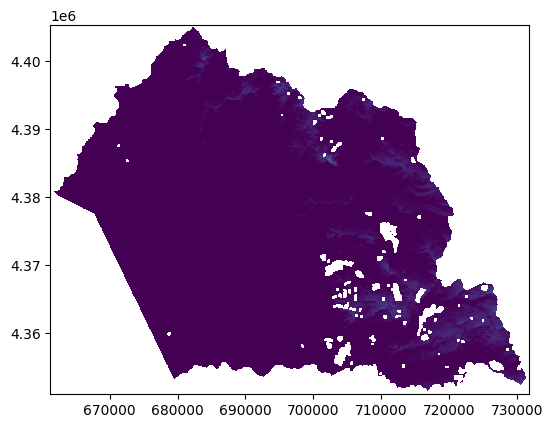

CRS.from_epsg(32610)

In [88]:
file = f"{filepath}/{files[-1]}"
tiff = rasterio.open(file)
show(tiff)
left,bottom,right,top = tiff.bounds
tiff.bounds
tiff.crs # looks like this is in UTM zone, probs want WGS84 for consistency? 

In [15]:
tiff.crs == rasterio.CRS.from_epsg(32611)

True

In [89]:
raster = rxr.open_rasterio(file)
transformed = raster.rio.reproject(rasterio.crs.CRS.from_epsg('4326'))
transformed[0]

<xarray.DataArray (y: 949, x: 1566)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 13kB -121.1 -121.1 -121.1 ... -120.3 -120.3 -120.3
  * y            (y) float64 8kB 39.78 39.78 39.78 39.78 ... 39.28 39.28 39.28
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

In [90]:
left, bottom, right, top = transformed.rio.bounds()
left

-121.12956578490564

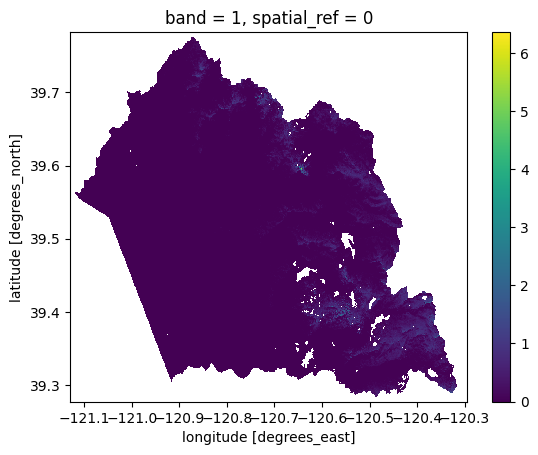

In [91]:
transformed.where(transformed > -1).plot()

In [93]:
daily = daymet.get_bygeom(tiff.bounds,dates=('2023-10-01','2024-05-27'),variables="prcp",crs=32611)
daily

<xarray.Dataset> Size: 2MB
Dimensions:                  (x: 76, y: 64, time: 92)
Coordinates:
  * x                        (x) float64 608B -1.24e+06 ... -1.165e+06
  * y                        (y) float64 512B -1.77e+05 -1.78e+05 ... -2.4e+05
  * time                     (time) datetime64[ns] 736B 2023-10-01 ... 2023-1...
    lambert_conformal_conic  int64 8B 0
Data variables:
    prcp                     (time, y, x) float32 2MB nan nan nan ... nan nan
    lat                      (y, x) float64 39kB nan nan nan nan ... nan nan nan
    lon                      (y, x) float64 39kB nan nan nan nan ... nan nan nan
Attributes:
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor...
    start_year:          2023
    source:              Daymet Software Version 4.0
    Version_data:        Daymet Data Version 4.0
    Version_software:    Daymet Software Version 4.0
    Conventions:         CF-1.6
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  39.15769321913411
    geospatial_lat_max:  39.89916477868125
    geospatial_lon_min:  -115.25582283175913
    geospatial_lon_max:  -114.18015791980736

In [94]:
daily['time']

<xarray.DataArray 'time' (time: 92)> Size: 736B
array(['2023-10-01T00:00:00.000000000', '2023-10-02T00:00:00.000000000',
       '2023-10-03T00:00:00.000000000', '2023-10-04T00:00:00.000000000',
       '2023-10-05T00:00:00.000000000', '2023-10-06T00:00:00.000000000',
       '2023-10-07T00:00:00.000000000', '2023-10-08T00:00:00.000000000',
       '2023-10-09T00:00:00.000000000', '2023-10-10T00:00:00.000000000',
       '2023-10-11T00:00:00.000000000', '2023-10-12T00:00:00.000000000',
       '2023-10-13T00:00:00.000000000', '2023-10-14T00:00:00.000000000',
       '2023-10-15T00:00:00.000000000', '2023-10-16T00:00:00.000000000',
       '2023-10-17T00:00:00.000000000', '2023-10-18T00:00:00.000000000',
       '2023-10-19T00:00:00.000000000', '2023-10-20T00:00:00.000000000',
       '2023-10-21T00:00:00.000000000', '2023-10-22T00:00:00.000000000',
       '2023-10-23T00:00:00.000000000', '2023-10-24T00:00:00.000000000',
       '2023-10-25T00:00:00.000000000', '2023-10-26T00:00:00.000000000',
       '2023-10-27T00:00:00.000000000', '2023-10-28T00:00:00.000000000',
       '2023-10-29T00:00:00.000000000', '2023-10-30T00:00:00.000000000',
       '2023-10-31T00:00:00.000000000', '2023-11-01T00:00:00.000000000',
       '2023-11-02T00:00:00.000000000', '2023-11-03T00:00:00.000000000',
       '2023-11-04T00:00:00.000000000', '2023-11-05T00:00:00.000000000',
       '2023-11-06T00:00:00.000000000', '2023-11-07T00:00:00.000000000',
       '2023-11-08T00:00:00.000000000', '2023-11-09T00:00:00.000000000',
       '2023-11-10T00:00:00.000000000', '2023-11-11T00:00:00.000000000',
       '2023-11-12T00:00:00.000000000', '2023-11-13T00:00:00.000000000',
       '2023-11-14T00:00:00.000000000', '2023-11-15T00:00:00.000000000',
       '2023-11-16T00:00:00.000000000', '2023-11-17T00:00:00.000000000',
       '2023-11-18T00:00:00.000000000', '2023-11-19T00:00:00.000000000',
       '2023-11-20T00:00:00.000000000', '2023-11-21T00:00:00.000000000',
       '2023-11-22T00:00:00.000000000', '2023-11-23T00:00:00.000000000',
       '2023-11-24T00:00:00.000000000', '2023-11-25T00:00:00.000000000',
       '2023-11-26T00:00:00.000000000', '2023-11-27T00:00:00.000000000',
       '2023-11-28T00:00:00.000000000', '2023-11-29T00:00:00.000000000',
       '2023-11-30T00:00:00.000000000', '2023-12-01T00:00:00.000000000',
       '2023-12-02T00:00:00.000000000', '2023-12-03T00:00:00.000000000',
       '2023-12-04T00:00:00.000000000', '2023-12-05T00:00:00.000000000',
       '2023-12-06T00:00:00.000000000', '2023-12-07T00:00:00.000000000',
       '2023-12-08T00:00:00.000000000', '2023-12-09T00:00:00.000000000',
       '2023-12-10T00:00:00.000000000', '2023-12-11T00:00:00.000000000',
       '2023-12-12T00:00:00.000000000', '2023-12-13T00:00:00.000000000',
       '2023-12-14T00:00:00.000000000', '2023-12-15T00:00:00.000000000',
       '2023-12-16T00:00:00.000000000', '2023-12-17T00:00:00.000000000',
       '2023-12-18T00:00:00.000000000', '2023-12-19T00:00:00.000000000',
       '2023-12-20T00:00:00.000000000', '2023-12-21T00:00:00.000000000',
       '2023-12-22T00:00:00.000000000', '2023-12-23T00:00:00.000000000',
       '2023-12-24T00:00:00.000000000', '2023-12-25T00:00:00.000000000',
       '2023-12-26T00:00:00.000000000', '2023-12-27T00:00:00.000000000',
       '2023-12-28T00:00:00.000000000', '2023-12-29T00:00:00.000000000',
       '2023-12-30T00:00:00.000000000', '2023-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time                     (time) datetime64[ns] 736B 2023-10-01 ... 2023-1...
    lambert_conformal_conic  int64 8B 0

In [13]:
daily_transformed = daily.rio.reproject(rasterio.crs.CRS.from_epsg('4326'))

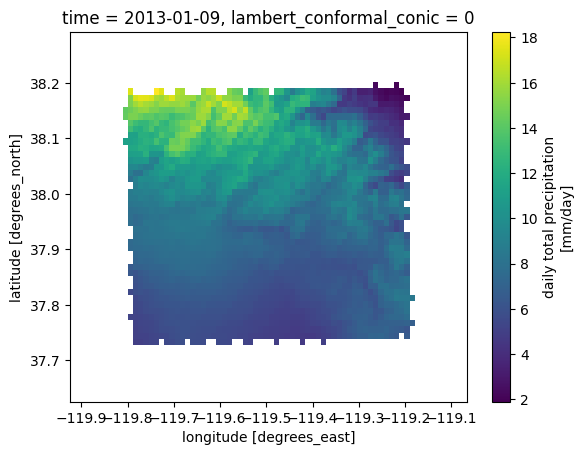

In [16]:
daily_transformed.sel(time='2013-01-09')['prcp'].plot.pcolormesh()

In [55]:
# cg1/Golitzin/SWEMLv2.0/data/TrainingDFs/2013/1000M_Resolution/2013_metadata.parquet
WY = [2015]
output_res=1000
meta_path = f"{HOME}/data/TrainingDFs/{WY[0]}/{output_res}M_Resolution/{WY[0]}_metadata.parquet"
# ASO_meta_path = f"{HOME}/data/TrainingDFs/{region}/{output_res}M_Resolution/ASO_meta.parquet"
meta = pd.read_parquet(meta_path)
# ASO_meta = pd.read_parquet(ASO_meta_path)

In [56]:
meta.head()

,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg
cell_id,,,,,
2015_1000M_37.665_-119.069,37.664594,-119.069352,2589,18,13
2015_1000M_37.665_-119.06,37.664594,-119.060352,2863,3,129
2015_1000M_37.665_-119.051,37.664594,-119.051352,2795,8,155
2015_1000M_37.665_-119.042,37.664594,-119.042352,2695,4,201
2015_1000M_37.665_-119.033,37.664594,-119.033352,2658,2,180


In [35]:
meta['cen_lat'].min(),meta['cen_lat'].max(),meta['cen_lon'].min(),meta['cen_lon'].max()

(36.55054629089285,
 38.189854229096795,
 -119.80125466655511,
 -106.17517498981225)

In [13]:
# choose a random point within study area to check precip values 
test_lat, test_lon = meta.iloc[500]['cen_lat'],meta.iloc[500]['cen_lon']
test_lat,test_lon

(38.00985404909662, -119.73825460355505)

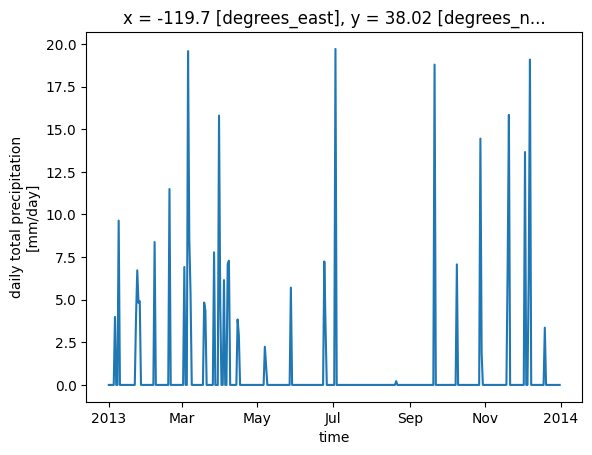

In [257]:
# check values, are the data real? 
daily_transformed.sel(x=test_lon,y=test_lat,method='nearest')['prcp'].plot()

In [14]:
ASO_Key=pd.read_csv(f"{HOME}/../ASOKey.csv",header=3)
ASO_Key.head()

,SITE CODE,SITE NAME,Easting,Northing,Easting.1,Northing.1,Easting.2,Northing.2,Easting.3,Northing.3,Unnamed: 10,Longitude,Latitude,Longitude.1,Latitude.1,Longitude.2,Latitude.2,Longitude.3,Latitude.3
0,USCABI,BISHOP BORESIGHT,373773,4139361,375072.0,4139361,373773,4137315,375072.0,4137315,11,-118.425986,37.39243,-118.411315,37.392603,-118.425636,37.37399,-118.410969,37.37417
1,USCABO,USCA_BODIE_GT,323145,4232547,325335.0,4232547,323145,4230381,325335.0,4230381,11,-119.020405,38.22354,-118.995401,38.223963,-119.019866,38.20403,-118.994868,38.20445
2,USCABP,BIG PINE,374427,4118148,384804.0,4118148,374427,4110342,384804.0,4110342,11,-118.415014,37.20136,-118.298109,37.202700,-118.413702,37.13102,-118.296907,37.13235
3,USCACE,CHERRY ELEANOR,242715,4234848,272748.0,4234848,242715,4206393,272748.0,4206393,11,-119.939137,38.22485,-119.596397,38.232936,-119.928888,37.96873,-119.587339,37.97674
4,USCACM,USCA_CHEMUNG_MINE_GT,311901,4247049,312420.0,4247049,311901,4246512,312420.0,4246512,11,-119.152633,38.35186,-119.146697,38.351970,-119.152489,38.34703,-119.146554,38.34713


In [15]:
# parse dates and site name from ASO observation
# code borrowed from ASOfigs
def filename_parse(filename):
    date = next(element for element in os.path.splitext(filename)[0].split("_") if element.startswith('20'))
    if date[4].isnumeric() == False:
        date_singleday = os.path.splitext(date)[0].split("-")[0]
        datetime_object = datetime.strptime(date_singleday, "%Y%b%d")
        date = datetime_object.strftime('%Y%m%d')
    #identify basin from site code if applicable, else identify basin from name
    if filename[:12] == "ASO_50M_SWE_":
        # print(file[12:18])
        sitecode = filename[12:18]
        index = ASO_Key['SITE CODE']==sitecode
        sitename=(ASO_Key.loc[index,'SITE NAME']).item().replace(" ","_")
        # print(sitename)
        newfilename = f"ASO_{sitename}_{sitecode}_{date}"
        # print(newfilename)
    else:
        sitename = os.path.splitext(filename)[0].split("_")[1]
        newfilename = f"ASO_{sitename}_{date}"
    return(date, newfilename)

In [16]:
# this is going to be very annoying
# fix later (7/16)
filename = files[-1] 
date, filename_std = filename_parse(filename)
date = datetime.strptime(date,'%Y%m%d')
date
date_str = datetime.strftime(date, '%Y-%m-%d')
date_str, filename_std

('2013-06-08', 'ASO_TUOLUMNE_RIVER_USCATB_20130608')

In [17]:
filename_std[4:]

'TUOLUMNE_RIVER_USCATB_20130608'

In [18]:
obs_start = datetime.strftime(datetime(date.year-1, 10, 1),'%Y-%m-%d')
obs_end = date_str
obs_start,obs_end

('2012-10-01', '2013-06-08')

In [19]:
tiff.crs

CRS.from_epsg(32611)

In [20]:
left,bottom,right,top = tiff.bounds
# add some padding to make sure all values in ASO obs are represented in daymet file
new_bounds = left-1500,bottom-1500,right+1500,top+1500
new_bounds[0]
new_bounds = rasterio.coords.BoundingBox(new_bounds[0],new_bounds[1],new_bounds[2],new_bounds[3])
print(tiff.bounds,'\n', new_bounds)

BoundingBox(left=254247.0, bottom=4179316.898203377, right=307347.107356518, top=4229667.0) 
 BoundingBox(left=252747.0, bottom=4177816.898203377, right=308847.107356518, top=4231167.0)


In [21]:
obs_precip = daymet.get_bygeom(new_bounds,dates=(obs_start,obs_end),variables="prcp",crs=32611)
obs_precip_transformed = obs_precip.rio.reproject(rasterio.crs.CRS.from_epsg('4326'))

In [22]:
obs_precip_transformed

<xarray.Dataset> Size: 5MB
Dimensions:                  (x: 79, y: 61, time: 250)
Coordinates:
  * x                        (x) float64 632B -119.9 -119.9 ... -119.1 -119.1
  * y                        (y) float64 488B 38.3 38.29 38.28 ... 37.63 37.62
  * time                     (time) datetime64[ns] 2kB 2012-10-01 ... 2013-06-08
    lambert_conformal_conic  int64 8B 0
Data variables:
    prcp                     (time, y, x) float32 5MB nan nan nan ... nan nan
    lat                      (y, x) float64 39kB nan nan nan nan ... nan nan nan
    lon                      (y, x) float64 39kB nan nan nan nan ... nan nan nan
Attributes:
    start_year:          2012
    source:              Daymet Software Version 4.0
    Version_software:    Daymet Software Version 4.0
    Version_data:        Daymet Data Version 4.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor...
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  37.596060777472196
    geospatial_lat_max:  38.32562549731051
    geospatial_lon_min:  -119.96727784772376
    geospatial_lon_max:  -119.02816894734475

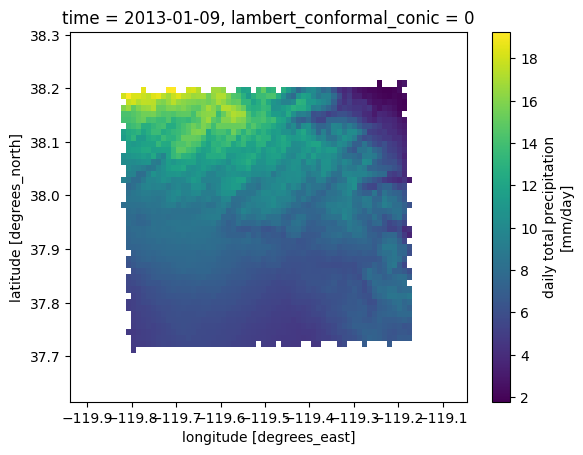

In [23]:
obs_precip_transformed.sel(time='2013-01-09')['prcp'].plot.pcolormesh()

In [24]:
obs_precip_transformed.sel(x=test_lon,y=test_lat,method='nearest')['prcp']

<xarray.DataArray 'prcp' (time: 250)> Size: 1kB
array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  3.43,  1.56,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  , 11.01, 21.84,  4.75,  1.95,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  , 13.15,  7.8 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        3.66, 21.25, 42.87, 10.2 ,  0.  ,  5.41,  3.81,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  , 20.33, 27.59, 69.03, 23.57, 60.5 ,
        0.  ,  0.  , 16.13,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
       18.12,  0.  ,  0.  ,  2.48,  7.63, 28.31,  6.73,  0.  ,  0.  ,
       14.79, 41.95, 46.2 ,  0.  , 21.13, 10.97,  0.  ,  0.  ,  2.63,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  3.39,  0.  ,  0.  ,
        8.93,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  4.05,  6.43,  4.28,  3.96,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  7.82,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  , 10.7 ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  5.82,
        0.  ,  0.  , 18.46,  7.82,  4.76,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  4.91,  4.26,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  5.75,  0.  ,  0.  ,  0.  ,
       15.7 ,  3.89,  0.  ,  0.  ,  5.07,  0.  ,  0.  ,  7.18,  7.47,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  3.68,  2.81,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  2.12,  1.21,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  5.2 ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ], dtype=float32)
Coordinates:
    x                        float64 8B -119.7
    y                        float64 8B 38.01
  * time                     (time) datetime64[ns] 2kB 2012-10-01 ... 2013-06-08
    lambert_conformal_conic  int64 8B 0
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    cell_methods:  area: mean time: sum
    _ChunkSizes:   [   1 1000 1000]
    _FillValue:    nan

In [25]:
# theoretically want seasonally accumulated precip up until ASO obs date for each obs
# possibly better to get daily precip values, then sum later when adding to training DF
# want to include basin label and date in any precip filename (per RJ)
precip_arr = []

nsites = len(meta)
# nsites = 100 # for now
for i in range(nsites):
    lat, lon = meta.iloc[i]['cen_lat'],meta.iloc[i]['cen_lon']
    cellid = meta.iloc[i].name
    prcp = obs_precip_transformed.sel(x=lon,y=lat,method='nearest')['prcp']
    precip_arr.append([cellid,lat,lon,np.array(prcp.values)])

In [26]:
precip_df = pd.DataFrame(precip_arr,columns = ['cell_id','cen_lat','cen_lon','precip'])
precip_df

,cell_id,cen_lat,cen_lon,precip
0,2013_1000M_38.181_-119.594,38.180854,-119.594254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2013_1000M_38.181_-119.585,38.180854,-119.585254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2013_1000M_38.172_-119.612,38.171854,-119.612254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2013_1000M_38.172_-119.603,38.171854,-119.603254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2013_1000M_38.172_-119.594,38.171854,-119.594254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
1483,2013_1000M_37.749_-119.288,37.748854,-119.288254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1484,2013_1000M_37.749_-119.279,37.748854,-119.279254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1485,2013_1000M_37.749_-119.27,37.748854,-119.270254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1486,2013_1000M_37.749_-119.261,37.748854,-119.261254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [378]:
Precippath

'/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0/data/Precipitation/2013/2013M_Daymet_Precip'

470
735.02997


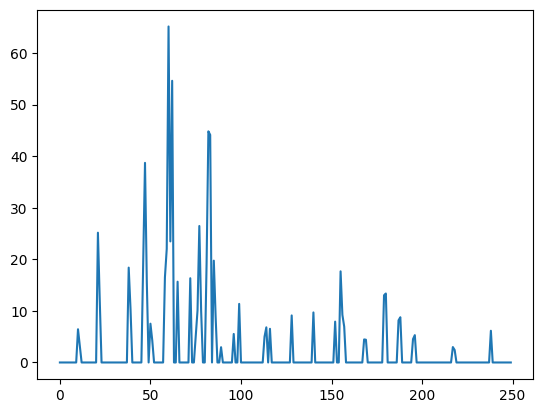

In [38]:
# check if values exist & are real
# choose a random cell and plot precip over WY
test_idx = np.random.randint(1,nsites,size=1)
print(test_idx[0])
print(precip_df.iloc[test_idx[0]]['precip'].sum())
plt.plot(precip_df.iloc[test_idx[0]]['precip'])
plt.show()

In [45]:
season_precip_cm = []
for i in range(nsites):
    season_precip_cm.append(np.round(precip_df.iloc[i]['precip'].sum()/10,2))

In [46]:
print(season_precip_cm[:50])
print(trainingDF.iloc[:50]['season_precip_cm'].values)

[79.82, 76.76, 78.89, 81.15, 77.03, 75.3, 80.08, 80.08, 76.12, 83.04, 83.04, 80.31, 80.31, 72.5, 76.64, 80.01, 80.7, 80.7, 81.39, 78.71, 71.68, 76.75, 76.75, 75.07, 79.14, 78.3, 79.72, 79.72, 78.58, 78.05, 71.36, 67.45, 83.28, 76.75, 76.75, 75.07, 79.14, 78.3, 79.72, 79.72, 78.58, 78.05, 73.79, 71.58, 71.58, 71.58, 71.36, 67.45, 79.53, 75.16]
[54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8
 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8
 54.8 54.8 54.8 39.  72.4 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8 54.8
 54.8 54.8 54.8 54.8 54.8 39.  72.4 54.8]


In [47]:
precip_df['season_precip_cm'] = season_precip_cm

In [48]:
precip_df.head()

,cell_id,cen_lat,cen_lon,precip,season_precip_cm
0,2013_1000M_38.181_-119.594,38.180854,-119.594254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",79.82
1,2013_1000M_38.181_-119.585,38.180854,-119.585254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",76.76
2,2013_1000M_38.172_-119.612,38.171854,-119.612254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",78.89
3,2013_1000M_38.172_-119.603,38.171854,-119.603254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",81.15
4,2013_1000M_38.172_-119.594,38.171854,-119.594254,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",77.03


In [52]:
year = 2013
output_res = 1000

Precippath = f"{HOME}/data/Precipitation/{year}/{output_res}M_Daymet_Precip"
if not os.path.exists(Precippath):
    os.makedirs(Precippath, exist_ok=True)

#Convert DataFrame to Apache Arrow Table
table = pa.Table.from_pandas(precip_df)
# Parquet with Brotli compression
pq.write_table(table, f"{Precippath}/Daymet_{filename_std[4:]}.parquet", compression='BROTLI')

In [39]:
# test_filepath = f'{HOME}/data/Precipitation/Southwest/1000M_NLDAS_Precip/sites/Southwest_1000M_37.816_-119.259.parquet'
# just wanna see what the old "sites" parquet looks like 
# just season accumulated precip for a single cell for all ASO obs dates at that cellid 
test_filepath = f'{HOME}/data/Precipitation/Southwest/1000M_NLDAS_Precip/sites/NLDAS_PPT_Southwest_1000M_38.181_-119.585.parquet'
test_file = pd.read_parquet(test_filepath)
test_file[test_file['datetime']=='2013-06-08']

,cell_id,datetime,season_precip_cm
5,Southwest_1000M_38.181_-119.585,2013-06-08,54.7556


In [358]:
test_file

,cell_id,datetime,season_precip_cm
0,Southwest_1000M_38.181_-119.585,2013-04-03,50.67136
1,Southwest_1000M_38.181_-119.585,2013-04-29,52.56862
2,Southwest_1000M_38.181_-119.585,2013-05-03,52.56862
3,Southwest_1000M_38.181_-119.585,2013-05-25,54.24213
4,Southwest_1000M_38.181_-119.585,2013-06-01,54.62097
...,...,...,...
94,Southwest_1000M_38.181_-119.585,2019-07-05,103.72204
95,Southwest_1000M_38.181_-119.585,2019-07-13,103.72204
96,Southwest_1000M_38.181_-119.585,2019-07-14,103.72204
97,Southwest_1000M_38.181_-119.585,2019-07-15,103.72204


In [40]:
# check structure of training DF w precip
filepath = f'{HOME}/data/TrainingDFs/2013/1000M_Resolution/PrecipVIIRSGeoObsDFs/20_fSCA_Thresh/Precip_VIIRS_GeoObsDF_20130608.parquet'
trainingDF = pd.read_parquet(filepath)
trainingDF.head()

,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,swe_m,ns_1,ns_2,ns_3,ns_4,ns_5,ns_6,VIIRS_SCA,hasSnow,season_precip_cm
cell_id,,,,,,,,,,,,,,,,
2013_1000M_38.181_-119.594,2013-06-08,38.181,-119.594,3055,41,119,0.016166,0.0,0.406451,-9999.0,0.0,-9999.0,0.0,50.000000,True,54.8
2013_1000M_38.181_-119.585,2013-06-08,38.181,-119.585,2922,32,82,0.027480,0.0,0.406451,-9999.0,0.0,-9999.0,0.0,6.000000,False,54.8
2013_1000M_38.172_-119.612,2013-06-08,38.172,-119.612,2976,6,211,0.051410,0.0,0.406451,-9999.0,0.0,0.0,0.0,6.000000,False,54.8
2013_1000M_38.172_-119.603,2013-06-08,38.172,-119.603,2890,17,78,0.003651,0.0,0.406451,-9999.0,0.0,0.0,0.0,0.000000,False,54.8
2013_1000M_38.172_-119.594,2013-06-08,38.172,-119.594,2871,3,117,0.049423,0.0,0.406451,-9999.0,0.0,-9999.0,0.0,1.833333,False,54.8


In [42]:
# compare random entry in new precip DF to old training DF
test_idx = np.random.randint(1,nsites,size=1)[0]
print('testing index',test_idx)
print('total daymet precip =',precip_df.iloc[test_idx]['precip'].sum()/10)
print(precip_df.iloc[test_idx]['cell_id'])
print(trainingDF.iloc[test_idx].name)
print('total NLDAS precip =',trainingDF.iloc[test_idx]['season_precip_cm'])

testing index 116
total daymet precip = 75.00800170898438
2013_1000M_38.1_-119.585
2013_1000M_38.1_-119.585
total NLDAS precip = 58.7


In [60]:
timedelt = datetime(2013,5,3)-datetime(2012,10,1)
timedelt.days

214

In [341]:
f"{HOME}/data/TrainingDFs/{region}/{output_res}M_Resolution/VIIRSGeoObsDFs/{20}_fSCA_Thresh"

'/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0/data/TrainingDFs/Southwest/1000M_Resolution/VIIRSGeoObsDFs/20_fSCA_Thresh'

In [54]:
WY = 2013
output_res = 1000
threshold = 20

In [65]:
def Make_Precip_DF(WY, output_res, threshold):

    print(f"Adding precipitation features to ML dataframe for {WY}.")
    Precippath = f"{HOME}/data/Precipitation/{WY}/{output_res}M_Daymet_Precip/"
    DFpath = f"{HOME}/data/TrainingDFs/{WY}/{output_res}M_Resolution/VIIRSGeoObsDFs/{threshold}_fSCA_Thresh"

    #make precip df path
    PrecipDFpath = f"{HOME}/data/TrainingDFs/{WY}/{output_res}M_Resolution/PrecipVIIRSGeoObsDFs/{threshold}_fSCA_Thresh"
    if not os.path.exists(PrecipDFpath):
        os.makedirs(PrecipDFpath, exist_ok=True)

    #Get list of dataframes
    GeoObsDF_files = [filename for filename in os.listdir(DFpath)]
    
    for geofile in GeoObsDF_files:
        single_date_add_precip((DFpath, Precippath, geofile, PrecipDFpath, WY))
    # print(GeoObsDF_files)
    # with cf.ProcessPoolExecutor(max_workers=CPUS) as executor: 
    #     # Start the load operations and mark each future with its process function
    #     [executor.submit(single_date_add_precip, (DFpath, Precippath, geofile, PrecipDFpath, WY)) for geofile in GeoObsDF_files]

In [73]:
Make_Precip_DF(WY,output_res,threshold)

Adding precipitation features to ML dataframe for 2013.
Connecting precipitation to ASO observations for 2013 on 2013-06-08
['Daymet_TUOLUMNE_RIVER_USCATB_20130608.parquet', '.ipynb_checkpoints']
Connecting precipitation to ASO observations for 2013 on 2013-04-03
['Daymet_TUOLUMNE_RIVER_USCATB_20130608.parquet', '.ipynb_checkpoints']


Exception: Failed to connect precip observations to dataframe

In [61]:
    pptfiles = [filename for filename in os.listdir(Precippath) if filename.endswith('parquet')]
    print(pptfiles)
    
pptfiles[0].split('_')[-1].split('.parquet')[0]

['Daymet_TUOLUMNE_RIVER_USCATB_20130608.parquet']


'20130608'

In [72]:
def single_date_add_precip(args):
    DFpath, Precippath, geofile, PrecipDFpath, WY = args
    #get date information
    date = geofile.split('VIIRS_GeoObsDF_')[-1].split('.parquet')[0]
    year = date[:4]
    mon = date[4:6]
    day = date[6:]
    strdate = f"{year}-{mon}-{day}"
    print(f"Connecting precipitation to ASO observations for {WY} on {strdate}")
    
    GDF = pd.read_parquet(os.path.join(DFpath, geofile))
    GDF.set_index('cell_id', inplace = True)
    GDF['season_precip_cm'] = 0.0
    
    # get precip filenames
    pptfiles = [filename for filename in os.listdir(Precippath)]
    print(pptfiles)
    
    ppt_idx = -1
    # connect GDF to correct precip file by date
    for i in range(len(pptfiles)):
        ppt_date = pptfiles[i].split('_')[-1].split('.parquet')[0]
        if ppt_date == date:
            ppt_idx = i
            break
    if ppt_idx > -1:     
        ppt = pd.read_parquet(f"{Precippath}/{pptfiles[ppt_idx]}")
    else:
        raise Exception('Failed to connect precip observations to dataframe')
        
    #get unique cells
    sites = list(GDF.index)
    for site in sites:
        try:
            GDF.loc[site,'season_precip_cm'] = round(ppt['season_precip_cm'][ppt['cell_id']== site].values[0],1)
        except:
            print(f"{site} is bad, delete file from folder and rerun the get precipitation script")

    #Convert DataFrame to Apache Arrow Table
    table = pa.Table.from_pandas(GDF)
    # Parquet with Brotli compression
    pq.write_table(table, f"{PrecipDFpath}/PrecipDaymet_{geofile}", compression='BROTLI')


In [75]:
new_training_df = pd.read_parquet(f'{HOME}/data/TrainingDFs/2013/1000M_Resolution/PrecipVIIRSGeoObsDFs/20_fSCA_Thresh/PrecipDaymet_VIIRS_GeoObsDF_20130608.parquet')
new_training_df.head()

,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,swe_m,ns_1,ns_2,ns_3,ns_4,ns_5,ns_6,VIIRS_SCA,hasSnow,season_precip_cm
cell_id,,,,,,,,,,,,,,,,
2013_1000M_38.181_-119.594,2013-06-08,38.181,-119.594,3055,41,119,0.016166,0.0,0.406451,-9999.0,0.0,-9999.0,0.0,50.000000,True,79.8
2013_1000M_38.181_-119.585,2013-06-08,38.181,-119.585,2922,32,82,0.027480,0.0,0.406451,-9999.0,0.0,-9999.0,0.0,6.000000,False,76.8
2013_1000M_38.172_-119.612,2013-06-08,38.172,-119.612,2976,6,211,0.051410,0.0,0.406451,-9999.0,0.0,0.0,0.0,6.000000,False,78.9
2013_1000M_38.172_-119.603,2013-06-08,38.172,-119.603,2890,17,78,0.003651,0.0,0.406451,-9999.0,0.0,0.0,0.0,0.000000,False,81.2
2013_1000M_38.172_-119.594,2013-06-08,38.172,-119.594,2871,3,117,0.049423,0.0,0.406451,-9999.0,0.0,-9999.0,0.0,1.833333,False,77.0


In [277]:
precip_df.iloc[1]['cell_id']

'2013_1000M_38.181_-119.585'

In [278]:
precip_df.iloc[1]['precip'].sum()/10

76.75700073242187

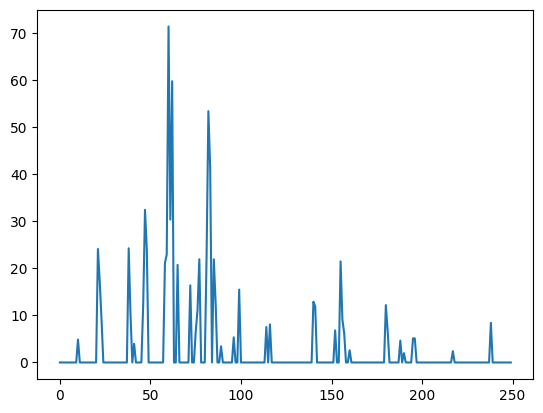

In [174]:
plt.plot(precip_df.iloc[1]['precip'])

In [132]:
old_file = pd.read_parquet(f'{HOME}/data/Precipitation/Northwest/1000M_NLDAS_Precip/sites/NLDAS_PPT_Northwest_1000M_47.888_-123.856.parquet')

In [145]:
meta.iloc[1].name

'Southwest_1000M_37.816_-119.259'

In [133]:
old_file

,cell_id,datetime,season_precip_cm
0,Northwest_1000M_47.888_-123.856,2016-02-08,159.54575
1,Northwest_1000M_47.888_-123.856,2016-03-29,228.25638


In [7]:
print(meta['cen_lat'].min(),meta['cen_lat'].max())
print(meta['cen_lon'].min(),meta['cen_lon'].max())

42.20017960055576 48.08635831647789
-124.1802179980171 -120.67740822143473


In [8]:
lat,long = meta[['cen_lat','cen_lon']].median()
location = ee.Geometry.Point(long,lat)

In [9]:
print(lat,long)

47.717357947477524 -123.52321734101645


In [8]:
startdate='2015-10'
enddate='2019-07'
precip = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('total_precipitation').filterDate(startdate, enddate)
daymet_precip = ee.ImageCollection("NASA/ORNL/DAYMET_V4").select('prcp').filterDate(startdate,enddate)

In [9]:
precip_poi = precip.getRegion(location,scale=1000).getInfo()

In [10]:
daymet_precip_poi = daymet_precip.getRegion(location,scale=1000).getInfo

In [15]:
pwd

'/uufs/chpc.utah.edu/common/home/civil-group1/Golitzin/SWEMLv2.0'

In [13]:
daymet_gdf = geemap.ee_to_df(daymet_precip_poi)

TypeError: ee_object must be an ee.FeatureCollection

In [11]:
site_precip = EE_funcs.ee_array_to_df(precip_poi,['total_precipitation'])
daymet_site_precip = EE_funcs.ee_array_to_df(daymet_precip_poi,['prcp'])

ValueError: DataFrame constructor not properly called!

In [36]:
temporal_resample = 'D'
kgm2_to_cm = 0.1

site_precip.set_index('datetime', inplace = True)
site_precip = site_precip.resample(temporal_resample).sum()
site_precip.reset_index(inplace = True)

        #make columns for cms
site_precip['total_precipitation'] = site_precip['total_precipitation']*kgm2_to_cm
site_precip.rename(columns={'total_precipitation':'daily_precipitation_cm'}, inplace = True)
site_precip.pop('time')
site_precip.set_index('datetime',inplace=True)


In [15]:
WYdict = {2016,2019}

,daily_precipitation_cm
datetime,
2017-09-10,0.06440
2017-09-11,0.00000
2017-09-12,0.00000
2017-09-13,0.00000
2017-09-14,0.00000
2017-09-15,0.00000
2017-09-16,0.00000
2017-09-17,0.85516
2017-09-18,0.81654


In [27]:
precip_daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4').select('prcp').filterDate(startdate, enddate)
precip_daymet_poi = precip_daymet.getRegion(location,scale=1000).getInfo()

In [32]:
site_precip_daymet = EE_funcs.ee_array_to_df(precip_daymet_poi,['prcp'])

In [39]:
site_precip_daymet['prcp'] /= 10
site_precip_daymet.pop('time')
site_precip_daymet.set_index('datetime',inplace=True)
site_precip_daymet.rename(columns={'prcp':'daily_precipitation_cm'},inplace=True)

In [40]:
site_precip_daymet

,daily_precipitation_cm
datetime,
2015-10-01,0.00
2015-10-02,0.00
2015-10-03,0.00
2015-10-04,0.00
2015-10-05,0.00
...,...
2019-06-26,0.00
2019-06-27,0.63
2019-06-28,0.00


Map(center=[47.717357947477524, -123.52321734101645], controls=(WidgetControl(options=['position', 'transparen…

Map(center=[47.717357947477524, -123.52321734101645], controls=(WidgetControl(options=['position', 'transparen…